<a href="https://colab.research.google.com/github/Strojove-uceni/105/blob/main/105_Machine_learning_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo 01](https://staff.utia.cas.cz/novozada/ml1/105.png)

**Course website:** [zoi.utia.cas.cz/ROZ2](http://zoi.utia.cas.cz/ROZ2/studijni-materialy)


# Part 1: RANSAC


**RANSAC - RANdom SAmple Consensus** is an iterative method to estimate parameters of a mathematical model from a set of observed data which contains outliers.

## Problem Description
**Imagine you have that kind of data:**

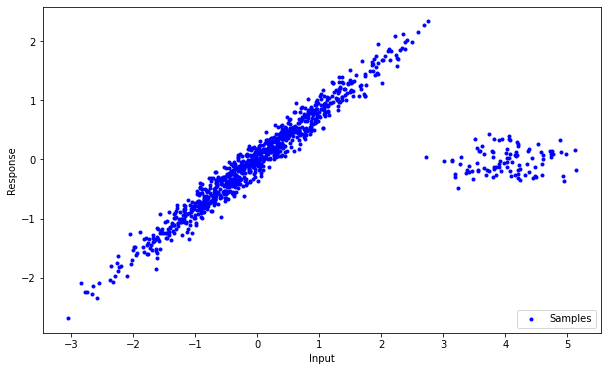

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

n_samples = 1000
n_outliers = 100

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=15,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 4 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -4 + 20 * np.random.normal(size=n_outliers)

y = y / 100

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='b', marker='.', label='Samples')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

**You need to find the model >> linear regression:**

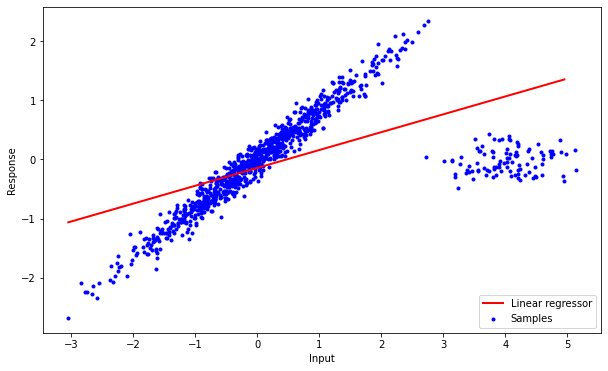

In [ ]:
from sklearn import linear_model

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Predict data of estimated models
X_lr_line = np.arange(X.min(), X.max())[:, None]
y_lr_line = lr.predict(X_lr_line)

lw = 2
plt.figure(figsize=(10,6))
plt.plot(X_lr_line, y_lr_line, color='r', linewidth=lw, label='Linear regressor')
plt.scatter(X, y, color='b', marker='.', label='Samples')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

The line is the **best line** (yielding the minimum MSE) we can fit, however, it looks wrong! The line doesn’t seem to describe the data!

## Algorithm RANSAC

### Step 1:
Randomly select samples from your dataset - 2 points in our case.

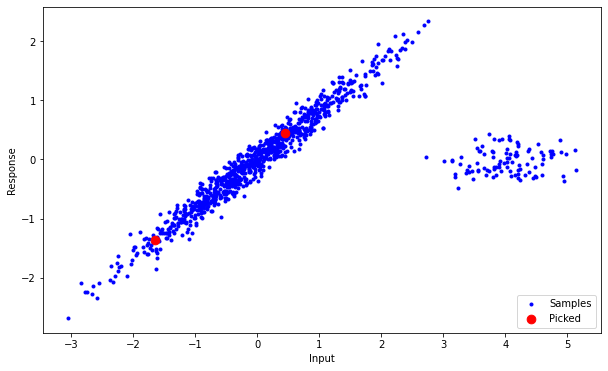

In [ ]:
idx = np.random.choice(X.shape[0], 2, replace=False)  

X_picked = X[idx]
y_picked = y[idx]

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='b', marker='.', label='Samples')
plt.scatter(X_picked, y_picked, color='r', marker='.', label='Picked', s=300)
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

### Step 2:
Use the random samples to fit a line, or whatever curve you are interested in.
In our case ➡ line: 

$$
\begin{align}\Large
r = \color{purple}{x \, \text{cos} \, \theta} + \color{orange}{y \, \text{sin} \, \theta} 
\end{align}
$$
<br />
<img src="https://staff.utia.cas.cz/novozada/ml1/line0.png">

$$
\begin{aligned}
r &= x_1 \, \text{cos} \, \theta + y_1 \, \text{sin} \, \theta \\
r &= x_2 \, \text{cos} \, \theta + y_2 \, \text{sin} \, \theta \\
x_1 \, \text{cos} \, \theta + y_1 \, \text{sin} \, \theta &= x_2 \, \text{cos} \, \theta + y_2 \, \text{sin} \, \theta \\
\text{cos} \, \theta (x_1 - x_2) &= \text{sin} \, \theta (y_2 - y_1) \\
\frac{\text{sin} \, \theta }{\text{cos} \, \theta} &= \frac{(x_1 - x_2)}{(y_2 - y_1)}
\end{aligned}
$$
<br />
$$
\begin{aligned} \Large
g(\theta, r) &= \left\{
    \begin{array}{cl}
    \Bigl(\frac{\pi}{2}, \, y_1 \Bigr) & \text{if } | y_2 - y_1 |  < 1\text{e}10 \\
    \Bigl( \text{arctan} \, \frac{(x_1 - x_2)}{(y_2 - y_1)}, \, x_1 \, \text{cos} \, \theta + y_1 \, \text{sin} \, \theta \Bigr) & \text{otherwise}
    \end{array}
    \right.    
\end{aligned}
$$
<br />

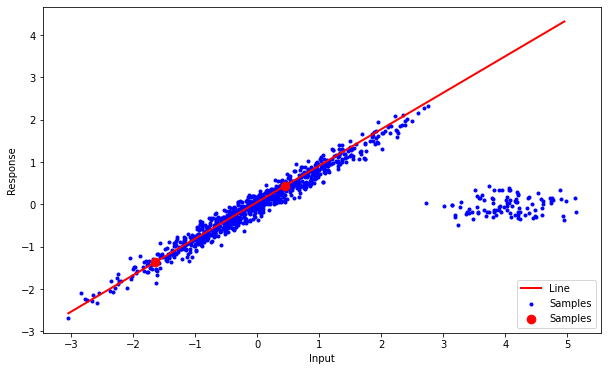

In [ ]:
import math

def find_line_model(X, y):        
  if np.abs(y[1]-y[0]) < 1e-10:
    theta = np.pi / 2
    r = y[1]    
  else:
    theta = (np.arctan((X[0]-X[1])/(y[1]-y[0])))
    r = X[0] * np.cos(theta) + y[0] * np.sin(theta)
  return r, theta

r, theta = find_line_model(X_picked, y_picked)
y_line = (r - X_lr_line * np.cos(theta)) / (np.sin(theta) + np.finfo(float).eps)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='b', marker='.', label='Samples')
plt.scatter(X_picked, y_picked, color='r', marker='.', label='Samples', s=300)
plt.plot(X_lr_line, y_line, color='r', linewidth=lw, label='Line')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

### Step 3:
Count how many data points are within a predefined distance to the line.
First we have to know how to calculate the distance of a point from a line:

<img src="https://staff.utia.cas.cz/novozada/ml1/line4.png">

$$
\begin{aligned}
\text{dist} &= (y_0 - b_y) \text{sin} \, \theta \\
r &= x_0 \, \text{cos} \, \theta + b_y \, \text{sin} \, \theta \\ 
b_y &= \frac{(r - x_0 \, \text{cos} \, \theta)}{\text{sin} \, \theta}\\ 
\end{aligned}
$$
<br />
$$
\begin{aligned} \Large
\text{dist} &= \left\{
    \begin{array}{cl}
    |y_0 - r| & \text{if } \; \text{sin} \, \theta < 1\text{e}10 \\
    \Bigl| \Bigl( y_0 - \frac{(r - x_0 \, \text{cos} \, \theta)}{\text{sin} \, \theta} \Bigr) \text{sin} \, \theta \Bigr| & \text{otherwise}
    \end{array}
    \right.    
\end{aligned}
$$
<br />

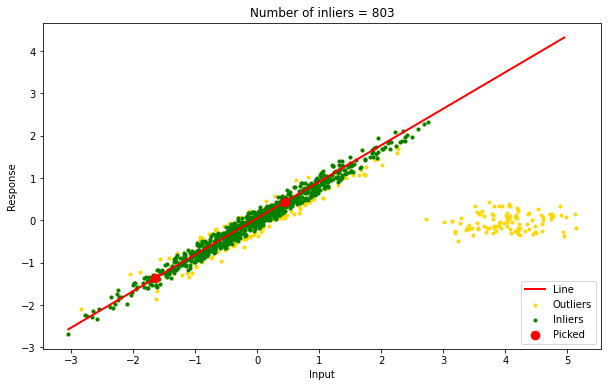

In [ ]:
import math

ransac_threshold = 0.2

def distance_from_line(theta, r, x0, y0):  
  if np.abs(np.sin(theta)) < 1e-10:
    dist = np.abs(y0 - r)    
  else:
    dist = np.abs((y0 - (r - x0*np.cos(theta))/np.sin(theta)) * np.sin(theta))
  return dist

# idx = np.random.choice(X.shape[0], 2, replace=False)  
# X_picked = X[idx]
# y_picked = y[idx]

r, theta = find_line_model(X_picked, y_picked)
y_line = (r - X_lr_line * np.cos(theta)) / (np.sin(theta) + np.finfo(float).eps)

x_list = []
y_list = []
num = 0
distance = 25
for ind in range(X.shape[0]):
  x0 = X[ind,0]
  y0 = y[ind]  
     
  # distance from point to the model
  dist = distance_from_line(theta, r, x0, y0)

  # check whether it's an inlier or not
  if dist < ransac_threshold:    
    x_list.append(x0)
    y_list.append(y0)
    num += 1

X_inliers = np.array(x_list)
y_inliers = np.array(y_list)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='gold', marker='.', label='Outliers')
plt.scatter(X_inliers, y_inliers, color='g', marker='.', label='Inliers')
plt.scatter(X_picked, y_picked, color='r', marker='.', label='Picked', s=300)
plt.plot(X_lr_line, y_line, color='r', linewidth=lw, label='Line')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.title(f"Number of inliers = {X_inliers.shape[0]}")
plt.show()

### Step 4:
Repeat the process several times with a new random sample each time.
We stop the algorithm when the number of **iteration** or **inliers** has been reached.

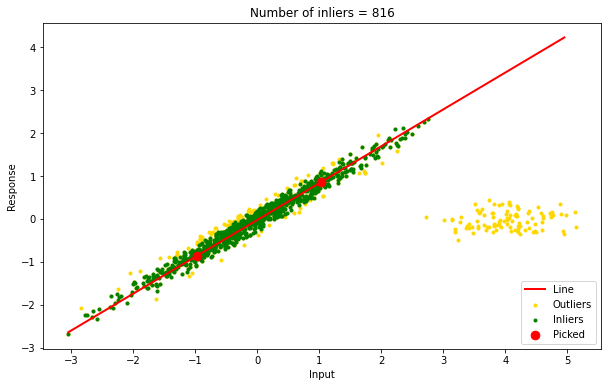

None

The model is found !


In [ ]:
import time
from IPython import display

ransac_iterations = 20
ransac_threshold = 0.2
ransac_ratio = 0.8

for idx_iter in range(ransac_iterations):
  idx = np.random.choice(X.shape[0], 2, replace=False)  

  X_picked = X[idx]
  y_picked = y[idx]

  r, theta = find_line_model(X_picked, y_picked)
  y_line = (r - X_lr_line * np.cos(theta)) / (np.sin(theta) + np.finfo(float).eps)

  x_list = []
  y_list = []
  num = 0  
  for ind in range(X.shape[0]):
    x0 = X[ind,0]
    y0 = y[ind]  
      
    # distance from point to the model
    dist = distance_from_line(theta, r, x0, y0)

    # check whether it's an inlier or not
    if dist < ransac_threshold:    
      x_list.append(x0)
      y_list.append(y0)
      num += 1

  X_inliers = np.array(x_list)
  y_inliers = np.array(y_list)

  plt.figure(figsize=(10,6))
  plt.scatter(X, y, color='gold', marker='.', label='Outliers')
  plt.scatter(X_inliers, y_inliers, color='g', marker='.', label='Inliers')
  plt.scatter(X_picked, y_picked, color='r', marker='.', label='Picked', s=300)
  plt.plot(X_lr_line, y_line, color='r', linewidth=lw, label='Line')
  plt.legend(loc='lower right')
  plt.xlabel("Input")
  plt.ylabel("Response")
  plt.title(f"Number of inliers = {X_inliers.shape[0]}")
  display.clear_output(wait=True)
  display.display(plt.show())
  time.sleep(1)    
  if num > n_samples * ransac_ratio:
    print('The model is found !')
    break

## Final code - in class

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import sys
import time
from IPython import display


class Ransac:
  def __init__(self, ransac_max_iterations=20, ransac_min_iterations=5, ransac_threshold = 3, ransac_ratio=0.6, plot_steps=False, plot_final=False):    
    self.ransac_max_iterations = ransac_max_iterations  # number of max iterations
    self.ransac_min_iterations = ransac_min_iterations  # number of max iterations
    self.ransac_threshold = ransac_threshold    # threshold
    self.ransac_ratio = ransac_ratio            # ratio of inliers required to assert that a model fits well to data
    self.n_picked = 6      
    self.model_theta = 0.
    self.model_r = 0.
    self.plot_steps = plot_steps
    self.plot_final = plot_final    
    self._X_lr_line = []
    self._X_inliers = []
    self._y_inliers = []
    self._iter = 0

  def fit(self, X, y):        
    ratio = 0.
    self._X_lr_line = np.arange(X.min(), X.max())[:, None]
    n_samples = X.shape[0]           
    for iter in range(self.ransac_max_iterations):          
      idx = np.random.choice(X.shape[0], 2, replace=False)  

      X_picked = X[idx]
      y_picked = y[idx]

      r, theta = self._find_line_model(X_picked, y_picked)      

      X_list = []
      y_list = []
      num = 0      
      for ind in range(X.shape[0]):
        x0 = X[ind,0]
        y0 = y[ind]  
                  
        dist = self._distance_from_line(theta, r, x0, y0)        
        if dist < self.ransac_threshold:    
          X_list.append(x0)
          y_list.append(y0)
          num += 1

      X_inliers = np.array(X_list)
      y_inliers = np.array(y_list)

      # in case a new model is better - cache it      
      if num/float(n_samples) > ratio:
        ratio = num/float(n_samples)
        self.model_theta = theta
        self.model_r = r        
        self.iter = iter
        self.X_inliers = X_inliers
        self.y_inliers = y_inliers

      # plot the current step
      if self.plot_steps:
        self._plot(iter, X, y, theta, r, X_inliers, y_inliers, X_picked, y_picked, final=False)

      # we are done in case we have enough inliers and we have exceeded the minimum number of iterations 
      if (num > n_samples * self.ransac_ratio and iter >= self.ransac_min_iterations):
        break               

    if self.plot_final:
      self._plot(self.iter, X, y, self.model_theta, self.model_r, self.X_inliers, self.y_inliers, [], [], final=True)
    print(f"The best model what we found:")
    print(f"  ratio = {ratio}")
    print(f"  model_theta = {self.model_theta}")
    print(f"  model_r = {self.model_r}")

  def _find_line_model(self, X, y):        
    if np.abs(y[1]-y[0]) < 1e-10:
      theta = np.pi / 2
      r = y[1]    
    else:
      theta = (np.arctan((X[0]-X[1])/(y[1]-y[0])))
      r = X[0] * np.cos(theta) + y[0] * np.sin(theta)
    return r, theta

  def _distance_from_line(self, theta, r, ax, ay):  
    if np.abs(np.sin(theta)) < 1e-10:
      dist = np.abs(ay - r)    
    else:
      dist = np.abs((ay - (r - ax*np.cos(theta))/np.sin(theta)) * np.sin(theta))
    return dist
      
  def _plot(self, iter, X, y, theta, r, X_inliers, y_inliers, X_picked, y_picked, final=False):    
    plt.figure("Ransac", figsize=(10., 6.))       
    y_line = (r - self._X_lr_line * np.cos(theta)) / (np.sin(theta) + np.finfo(float).eps)

    if not final:
      plt.scatter(X, y, color='gold', marker='.', label='Outliers')
      plt.scatter(X_inliers, y_inliers, color='g', marker='.', label='Inliers')
      plt.scatter(X_picked, y_picked, color='r', marker='.', label='Picked', s=300)    
      plt.plot(self._X_lr_line, y_line, color='r', linewidth=2, label='Line')
      plt.title(f"Iteration: {iter+1} - Number of inliers = {X_inliers.shape[0]}")
    else:
      plt.scatter(X, y, color='gold', marker='.', label='Points')            
      plt.plot(self._X_lr_line, y_line, color='r', linewidth=5, label='Line')
      plt.title(f"Final results with {X_inliers.shape[0]} inliers - Iteration: {iter}")    
    
    plt.legend(loc='lower right')
    plt.xlabel("Input")
    plt.ylabel("Response")    
    display.clear_output(wait=True)
    display.display(plt.show())
    time.sleep(2)    
    plt.close()

### Usage

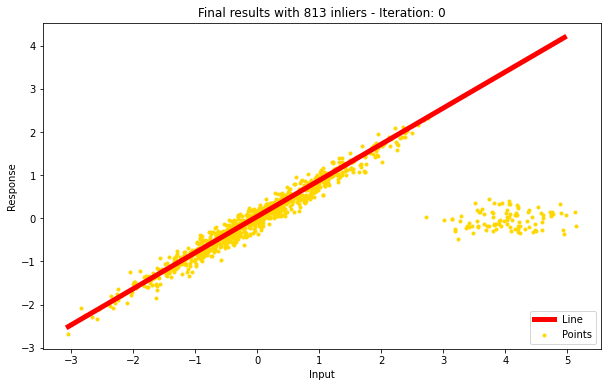

None

The best model what we found:
  ratio = 0.813
  model_theta = [-0.87339064]
  model_r = [-0.03151368]


In [ ]:
rsc = Ransac(ransac_max_iterations=20,
             ransac_min_iterations=5,
             ransac_threshold = 0.2,
             ransac_ratio=0.7,
             plot_steps=True,
             plot_final=True)
rsc.fit(X, y)

## Example - practical use of RANSAC in everyday life - IMAGE STITCHING

0.   Image loading and preprocessing
1.   Keypoint detection & Local invariant descriptors (**BRISK**, ORB, SIFT, SURF, etc)
2.   Feature matching (k-NN)
3.   **Homography estimation using RANSAC**
4.   Perspective warping


### 0. Image loading and preprocessing

--2022-12-06 07:30:15--  https://staff.utia.cas.cz/novozada/ml1/cards01.png
Resolving staff.utia.cas.cz (staff.utia.cas.cz)... 147.231.16.197
Connecting to staff.utia.cas.cz (staff.utia.cas.cz)|147.231.16.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 652827 (638K) [image/png]
Saving to: ‘img1.png’

img1.png            100%[===================>] 637.53K   476KB/s    in 1.3s    

2022-12-06 07:30:17 (476 KB/s) - ‘img1.png’ saved [652827/652827]

--2022-12-06 07:30:17--  https://staff.utia.cas.cz/novozada/ml1/cards02.png
Resolving staff.utia.cas.cz (staff.utia.cas.cz)... 147.231.16.197
Connecting to staff.utia.cas.cz (staff.utia.cas.cz)|147.231.16.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606768 (593K) [image/png]
Saving to: ‘img2.png’

img2.png            100%[===================>] 592.55K   478KB/s    in 1.2s    

2022-12-06 07:30:18 (478 KB/s) - ‘img2.png’ saved [606768/606768]



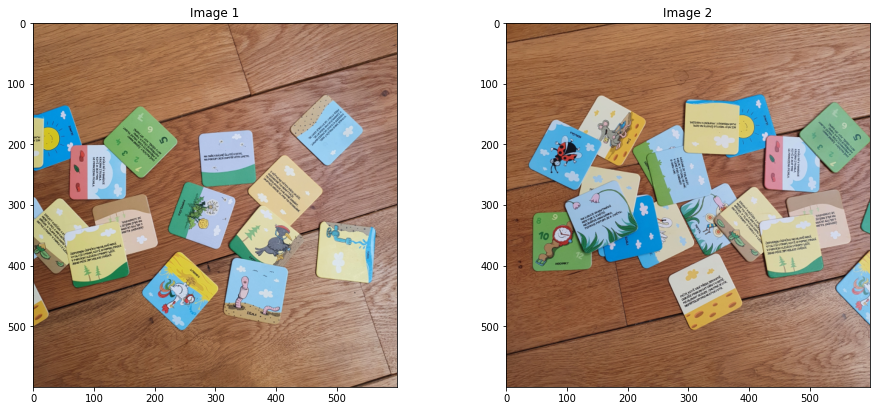

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Download images to workspace
!wget https://staff.utia.cas.cz/novozada/ml1/cards01.png -O img1.png
!wget https://staff.utia.cas.cz/novozada/ml1/cards02.png -O img2.png
# !wget https://staff.utia.cas.cz/novozada/ml1/home01.png -O img1.png
# !wget https://staff.utia.cas.cz/novozada/ml1/home02.png -O img2.png

img1 = cv2.imread('img1.png', cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

img2 = cv2.imread('img2.png', cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
ax1.imshow(img1)
ax1.set_title("Image 1")
ax2.imshow(img2)
ax2.set_title("Image 2")
plt.show()

### 1. Keypoint detection & Local invariant descriptors

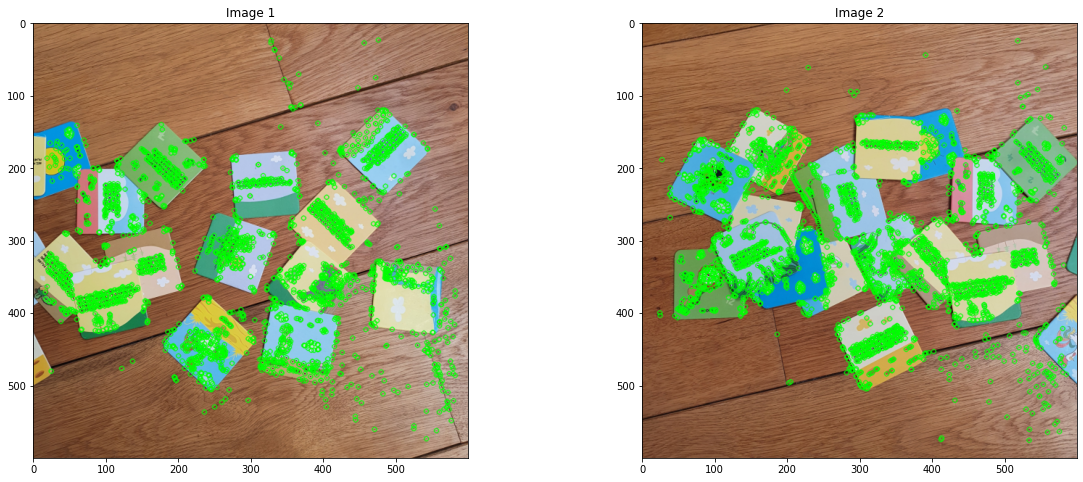

In [ ]:
import numpy as np

descriptor = cv2.BRISK_create()

kps1, features1 = descriptor.detectAndCompute(img1_gray, None)
kps2, features2 = descriptor.detectAndCompute(img2_gray, None)

# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1, kps1, None, color=(0, 255, 0)))
ax1.set_title("Image 1")
ax2.imshow(cv2.drawKeypoints(img2, kps2, None, color=(0, 255, 0)))
ax2.set_title("Image 2")
plt.show()

### 2. Feature matching (k-NN)

Raw matches (k-NN): 2457


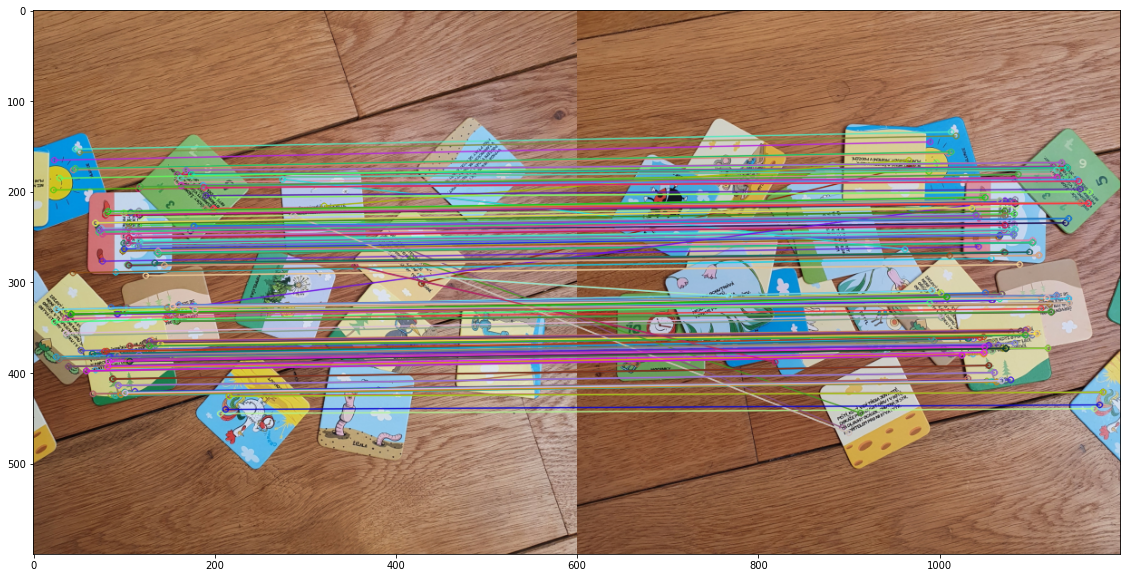

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
# k-NN 
rawMatches = bf.knnMatch(features1, features2, 2)
print("Raw matches (k-NN):", len(rawMatches))
matches = []
for m,n in rawMatches:
    if m.distance < n.distance * 0.75:
        matches.append(m)

img3 = cv2.drawMatches(img1,kps1,img2,kps2,np.random.choice(matches,300),
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(20,10))
plt.imshow(img3)
plt.show()

### 3. + 4. Homography estimation using RANSAC + warping

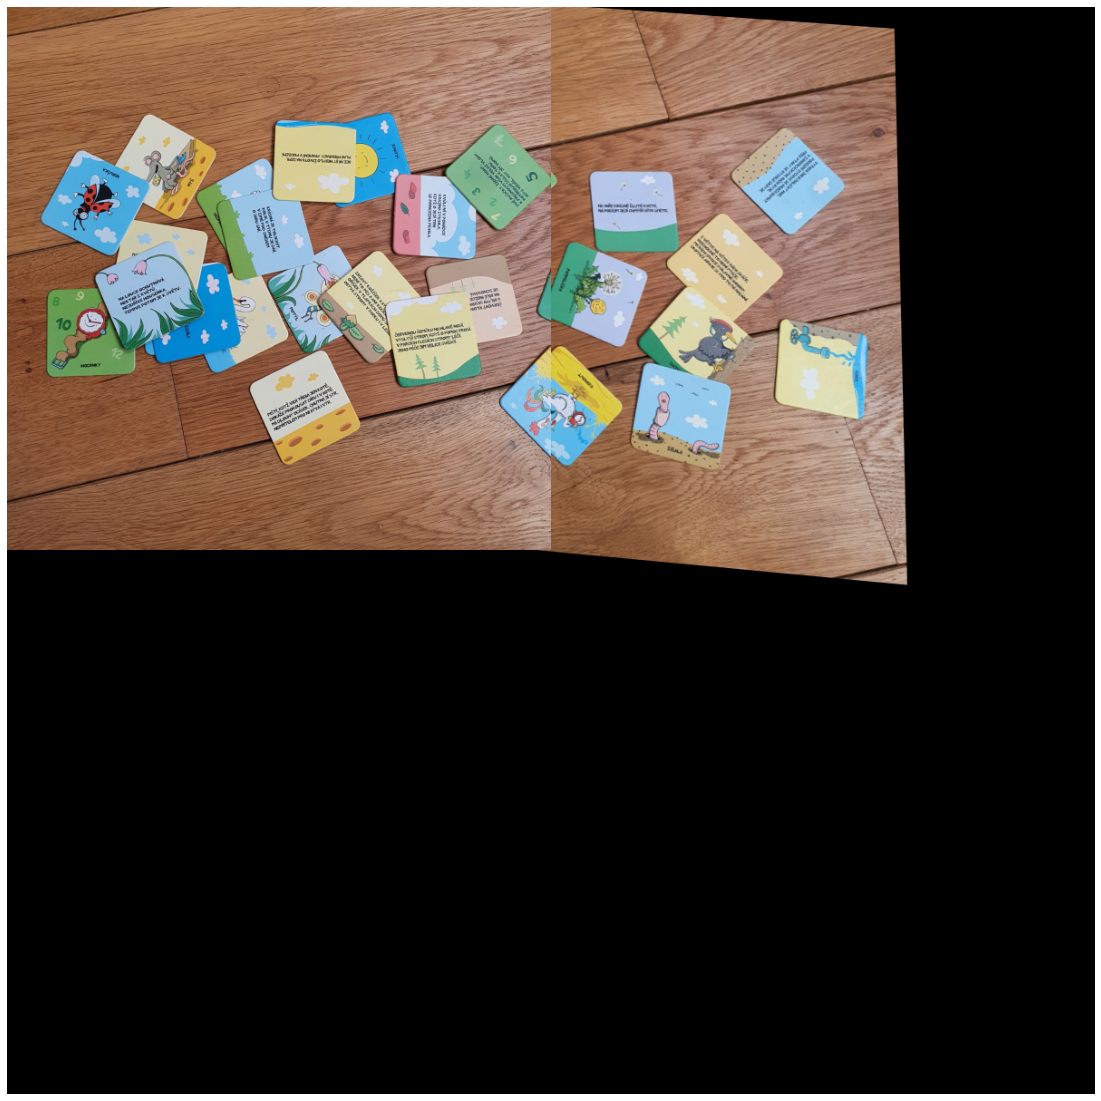

In [ ]:
# convert the keypoints to numpy arrays
kps1np = np.float32([kp.pt for kp in kps1])
kps2np = np.float32([kp.pt for kp in kps2])

# construct the two sets of points
pts1 = np.float32([kps1np[m.queryIdx] for m in matches])
pts2 = np.float32([kps2np[m.trainIdx] for m in matches])

if len(matches) > 4:
  # estimate the homography between the sets of points
  (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, 0.1)
  # Apply panorama correction
  width = img1.shape[1] + img2.shape[1]
  height = img1.shape[0] + img2.shape[0]

  result = cv2.warpPerspective(img1, H, (width, height))
  result[0:img2.shape[0], 0:img2.shape[1]] = img2
  
  plt.figure(figsize=(20,20))
  plt.imshow(result)

  plt.axis('off')
  plt.show()
else:
  print(f"We need 5 matches, but we have only {len(matches)}")  

# Part 2: AdaBoost


## Goal
**Boosting** is a general strategy for learning classifiers by combining several weak ones to get one strong classifier at the end. **AdaBoost** is one of the most popular boosting algorithms (adaptive ➡ Ada)

<img src="https://staff.utia.cas.cz/novozada/ml1/adaboost.png">

## Algorithm AdaBoost


### Fitting:
*   Prepare the data:
      * $X$ ... [samples x features]
      * $y$ ... classes [samples x 1]
      * $N$ ... number of samples
      * $N_{C}$ ... number of weak classifiers 
      * $x_i$ ... one sample
      * $f_C(x_i)$ ... prediction value of week classifier trained with weights

*   Select the appropriate weak classifier - Decision Tree
*   Initialize weights for each sample: $w_i = \frac{1}{N}$

>**for** $C=1$ to $N_{C}$ **do**
>> fit weak classifier with weights to minimize the objective function:
$$
\begin{aligned}
ϵ_C = \frac{\sum_{i=1}^{N}{w_i^{C}I(f_C(x_i), y_i)}}{\sum_i{w_i^{C}}}
\end{aligned}
$$

<br />
$$
\begin{aligned}
I(f_C(x_i), y_i) &= \left\{
    \begin{array}{cl}
    0 & \text{if } f_C(x_i) = y \\
    1 & \text{if } f_C(x_i) \neq y 
    \end{array}
    \right.    
\end{aligned}
$$
<br />

>> count classifier weigh - $\alpha_C = \text{ln}\frac{1-ϵ_C}{ϵ_C}$

>> **for** all $i=1$ to $N$ **do** 
>>> $w_i^{C+1}=w_i^{C}e^{\alpha_C I(f_m(x_i),y_i)}\,\,\,\,$ *(update)*



### Predicting:
The final classifier is based on a linear combination of the weak classifiers:

<br />
$$
\begin{aligned}
g(x) = \text{sign} \Bigg( \sum_{C=1}^{N_C}{\alpha_C f_C(x)}\Bigg)
\end{aligned}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier

class AdaBoost:
  def __init__(self, n_classifier=5):    
    self.classifier_list = []
    self.y_predict_list = []
    self.classifier_error_list = []
    self.classifier_weight_list = []
    self.sample_weight_list = []
    self.n_classifier = n_classifier        
    self.colormap = ListedColormap(['#FF0000', '#0000FF'])       

  def fit(self, X, y):
    self.X = X
    self.y = y
    N = len(y)        
        
    # Initialize the sample weights
    sample_weight = np.ones(N) / N
    self.sample_weight_list.append(sample_weight.copy())
    
    for idx_clf in range(self.n_classifier):   
      # Fit a classifier      
      classifier = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)            
      classifier.fit(self.X, self.y, sample_weight=sample_weight)      
      y_predict = classifier.predict(self.X)

      # Misclassifications
      incorrect = (y_predict != self.y)

      # Classifier error
      classifier_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
                  
      # Boost classifier weights
      classifier_weight =  np.log((1. - classifier_error) / classifier_error)
      
      # Boost sample weights                  
      sample_weight *= np.exp(classifier_weight * incorrect * ((sample_weight > 0) | (classifier_weight < 0)))
      
      # Save iteration values
      self.classifier_list.append(classifier)
      self.y_predict_list.append(y_predict.copy())
      self.classifier_error_list.append(classifier_error.copy())
      self.classifier_weight_list.append(classifier_weight.copy())
      self.sample_weight_list.append(sample_weight.copy())
        
    # Convert to np array
    self.classifier_list = np.asarray(self.classifier_list)
    self.y_predict_list = np.asarray(self.y_predict_list)
    self.classifier_error_list = np.asarray(self.classifier_error_list)
    self.classifier_weight_list = np.asarray(self.classifier_weight_list)
    self.sample_weight_list = np.asarray(self.sample_weight_list)    

  def predict(self, X):
    N = X.shape[0]
    y_preds = [weight * classifier.predict(X) for classifier, weight in zip(self.classifier_list, self.classifier_weight_list)]
    y_preds = np.sum(y_preds, axis=0)
    y_preds = np.asarray(np.sign(y_preds))
    return y_preds

  def plot_init(self):
    ax = plt.gca()
    ax.scatter(self.X[:,0],self.X[:,1], c = self.y, cmap = self.colormap)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
  def plot_final(self, classifiers, classifier_weights, N = 50):    
    def AdaBoost_classify(x_temp, est,est_weights):      
      temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
      return np.sign(temp_pred.sum(axis = 0))
       
    ax = plt.gca()
    x_min, x_max = self.X[:, 0].min() - .1, self.X[:, 0].max() + .1
    y_min, y_max = self.X[:, 1].min() - .1, self.X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    zz = np.array( [AdaBoost_classify(np.array([xi,yi]).reshape(1,-1), classifiers,classifier_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] ) 
    Z = zz.reshape(xx.shape)

    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(self.X[:,0],self.X[:,1], c = self.y, cmap = self.colormap)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

  def plot_decision_boundary(self, classifier, N, scatter_weights):
    ax = plt.gca()
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))    

    zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )    
    Z = zz.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(self.X[:,0],self.X[:,1], c = self.y, cmap = self.colormap, s = scatter_weights * 40)   
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')    

**Let's try a toy example - net $10 \, \text{x} \, 10$**

Accuracy = 1.0


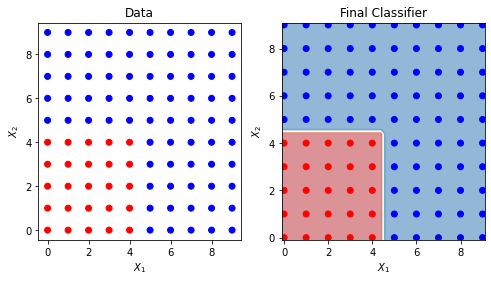

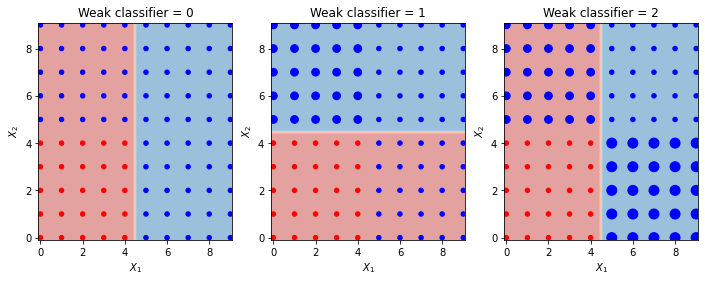

In [ ]:
import math
x1, x2 = np.meshgrid( np.arange(0,10),np.arange(0,10))
X = np.vstack((np.ravel(x1),np.ravel(x2))).T
y = np.ones(x1.shape)
y[:math.floor(y.shape[0]/2), :math.floor(y.shape[1]/2)] = -1
y = np.ravel(y)

clf = AdaBoost(n_classifier=3)
clf.fit(X, y)

y_preds = clf.predict(X);

print(f"Accuracy = {np.sum(y_preds == y) / len(y)}")

fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,2,1)
clf.plot_init()
plt.title('Data')
fig.add_subplot(1,2,2)
clf.plot_final(clf.classifier_list, clf.classifier_weight_list, N = 50)
plt.title('Final Classifier')

cols = 4
rows = math.ceil(clf.n_classifier / cols)
fig = plt.figure(figsize = (cols*4,rows*4))
for idx_clf in range(0,clf.n_classifier):  
    fig.add_subplot(rows,cols,idx_clf+1)
    s_weights = (clf.sample_weight_list[idx_clf,:]) * 50          
    clf.plot_decision_boundary(clf.classifier_list[idx_clf], 50, s_weights)
    plt.title(f"Weak classifier = {idx_clf}")

**What if we randomly take some points off the net?**

Accuracy = 1.0


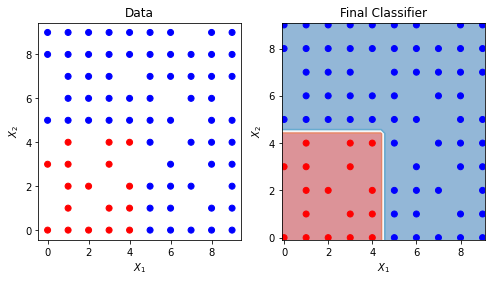

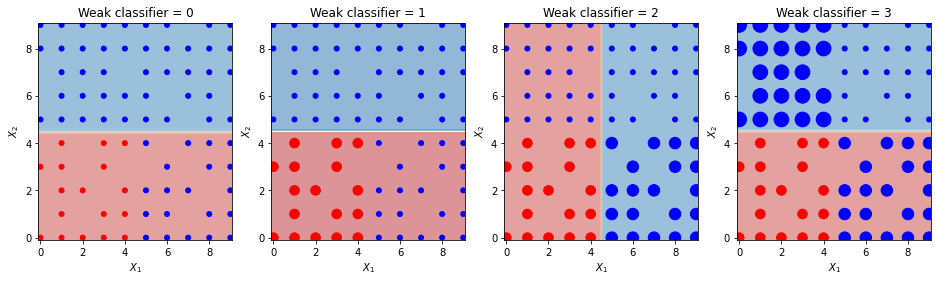

In [ ]:
from sklearn.model_selection import train_test_split
import math
x1, x2 = np.meshgrid( np.arange(0,10),np.arange(0,10))
X = np.vstack((np.ravel(x1),np.ravel(x2))).T
y = np.ones(x1.shape)
y[:math.floor(y.shape[0]/2), :math.floor(y.shape[1]/2)] = -1
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

clf = AdaBoost(n_classifier=4)
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test);

print(f"Accuracy = {np.sum(y_preds == y_test) / len(y_test)}")

fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,2,1)
clf.plot_init()
plt.title('Data')
fig.add_subplot(1,2,2)
clf.plot_final(clf.classifier_list, clf.classifier_weight_list, N = 50)
plt.title('Final Classifier')

cols = 4
rows = math.ceil(clf.n_classifier / cols)
fig = plt.figure(figsize = (cols*4,rows*4))
for idx_clf in range(0,clf.n_classifier):  
    fig.add_subplot(rows,cols,idx_clf+1)
    s_weights = (clf.sample_weight_list[idx_clf,:]) * 50          
    clf.plot_decision_boundary(clf.classifier_list[idx_clf], 50, s_weights)
    plt.title(f"Weak classifier = {idx_clf}")

Accuracy = 1.0


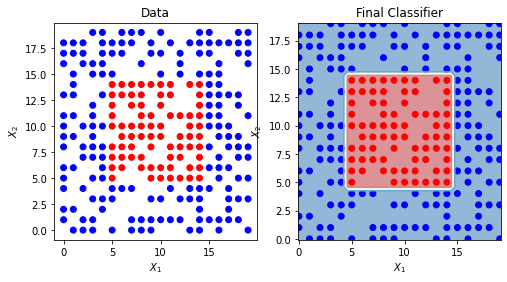

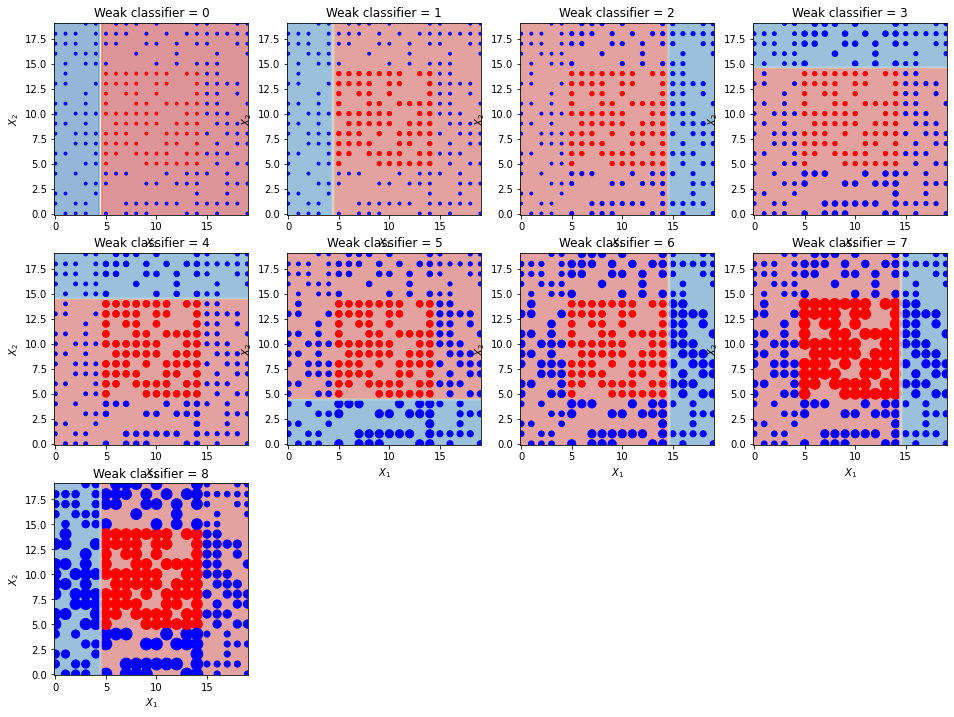

In [ ]:
from sklearn.model_selection import train_test_split
import math
x1, x2 = np.meshgrid( np.arange(0,20),np.arange(0,20))
X = np.vstack((np.ravel(x1),np.ravel(x2))).T
y = np.ones(x1.shape)
y[math.floor(y.shape[0]/4):math.floor(y.shape[0]/4)*3,math.floor(y.shape[1]/4) :math.floor(y.shape[1]/4)*3] = -1
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

clf = AdaBoost(n_classifier=9)
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test);

print(f"Accuracy = {np.sum(y_preds == y_test) / len(y_test)}")

fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,2,1)
clf.plot_init()
plt.title('Data')
fig.add_subplot(1,2,2)
clf.plot_final(clf.classifier_list, clf.classifier_weight_list, N = 50)
plt.title('Final Classifier')

cols = 4
rows = math.ceil(clf.n_classifier / cols)
fig = plt.figure(figsize = (cols*4,rows*4))
for idx_clf in range(0,clf.n_classifier):  
    fig.add_subplot(rows,cols,idx_clf+1)
    s_weights = (clf.sample_weight_list[idx_clf,:]) * 50          
    clf.plot_decision_boundary(clf.classifier_list[idx_clf], 50, s_weights)
    plt.title(f"Weak classifier = {idx_clf}")

**What about a little more complicated data distribution?**
*   We need more weak classifiers
*   The fit method is fast, but the visualization is slow, because of the prediction of the high number of DecisionTrees

Accuracy = 0.92


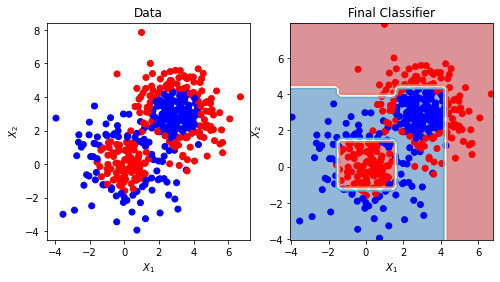

In [ ]:
from sklearn.datasets import make_gaussian_quantiles


# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

clf = AdaBoost(n_classifier=20)
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test);

print(f"Accuracy = {np.sum(y_preds == y_test) / len(y_test)}")

fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,2,1)
clf.plot_init()
plt.title('Data')
fig.add_subplot(1,2,2)
clf.plot_final(clf.classifier_list, clf.classifier_weight_list, N = 50)
plt.title('Final Classifier');

**What if we have more than two features?**

*   It is not possible to use the visualization functions in our AdaBoost class!



In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data.data, data.target

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

clf = AdaBoost(n_classifier=8)
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test);

print(f"Accuracy = {np.sum(y_preds == y_test) / len(y_test)}")

Accuracy = 0.9649122807017544


**But we can also select only 2 features**
*   But even using only 2 features out of 30 we have a very good success rate!

Accuracy = 0.9210526315789473


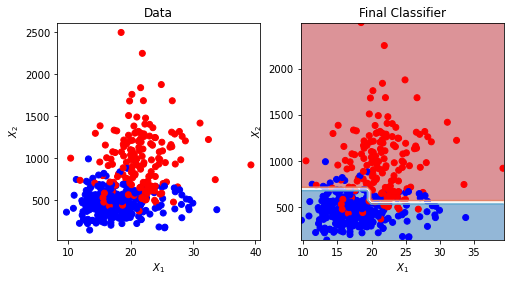

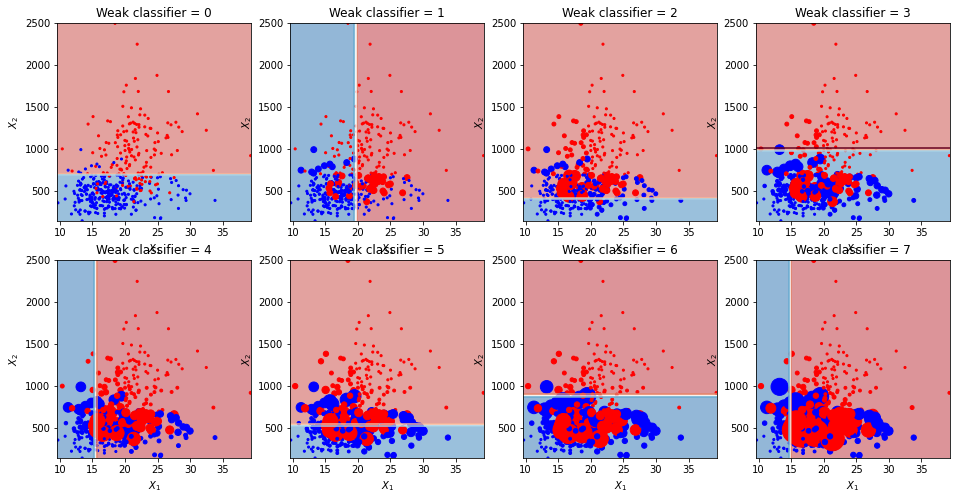

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data.data, data.target
X = X[:, [1, 3]]

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

clf = AdaBoost(n_classifier=8)
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test);

print(f"Accuracy = {np.sum(y_preds == y_test) / len(y_test)}")

fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,2,1)
clf.plot_init()
plt.title('Data')
fig.add_subplot(1,2,2)
clf.plot_final(clf.classifier_list, clf.classifier_weight_list, N = 50)
plt.title('Final Classifier')

cols = 4
rows = math.ceil(clf.n_classifier / cols)
fig = plt.figure(figsize = (cols*4,rows*4))
for idx_clf in range(0,clf.n_classifier):  
    fig.add_subplot(rows,cols,idx_clf+1)
    s_weights = (clf.sample_weight_list[idx_clf,:]) * 50          
    clf.plot_decision_boundary(clf.classifier_list[idx_clf], 50, s_weights)
    plt.title(f"Weak classifier = {idx_clf}")